# Visualisation Tools

## Introduction

While numerical metrics provide a quantitative measure of uncertainty, visualizations offer an intuitive, qualitative understanding of a model's predictions. A single plot can often reveal the nature of a model's confidence in a way that is difficult to grasp from numbers alone. To this end, probly provides specialized tools for plotting predictive distributions, focusing on classification tasks.

Currently, the plotting module is designed to visualize the outputs of 3-class classifiers on a 2D simplex. This is a triangle where each corner represents 100% confidence in one of the three classes.

The library provides two main functions for this:

    The Simplex Plot is used to scatter individual predictions on this triangle, allowing you to see the distribution of a model's predictions across a dataset.

    The Credal Set Plot is a more advanced tool for visualizing the uncertainty of a single prediction derived from multiple samples (e.g., from an ensemble or MC-Dropout). It plots the region of all possible probability distributions consistent with the model's outputs. A small, tight region indicates high confidence, while a large, spread-out region signifies high uncertainty.

These tools are essential for the qualitative interpretation and debugging of classification uncertainty.

## 0. First things first:
All modules mentioned here have more in depth notebooks to explain more detailed, how they are working.
You can find them under the section further reading.

## 1. What can you visualize in probly?
### Credal Sets: <br>
Based on the number of classes given in the visualizer, the `credal` package chooses between those three modules:

- **Intervall plot** / `plot_2d`: Quick sanity checks for two-feature views (or 2D embeddings): cluster overlap, separation, and how uncertainty behaves in feature space.

- **Ternary plot** / `plot_3d`: Visualization of **3-class probability vectors** on a simplex: highlights confident regions (near corners) vs. ambiguous regions (towards the center / edges).

- **Spider plot** / `plot_multid`: Multi-class probability diagnostics when `n_classes > 3`: compact views to spot systematic uncertainty patterns across many classes.


### Specialized plots:<br>
Upon our credal package, you can also visualize special plots:
- `plot_uncertainty`: Visualizes **margin-based confidence** between two 2D clusters by mapping the SVM decision margin into a smooth field.

- `plot_dirichlet`: Plots **Dirichlet density contours** on the ternary simplex to illustrate “distributions over probabilities” (concentration, symmetry, and skew).

- `plot_coverage_efficency`: Shows the **trade-off between empirical coverage and prediction set size** across confidence levels (coverage vs. efficiency on a dual-axis view)

## 2. Imports
To demonstrate, first let's import the following modules:

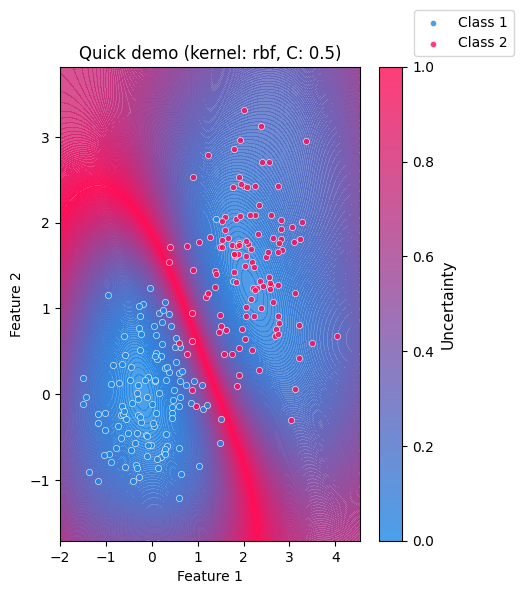

Imports successfully loaded.


In [1]:
import matplotlib.pyplot as plt
import numpy as np

from probly.visualization.clustermargin.clustervisualizer import plot_uncertainty
from probly.visualization.dirichlet.dirichlet_visualization import create_dirichlet_plot

try:
    from probly.visualization.credal.credal_visualization import create_credal_plot
except ImportError:
    from credal_visualization import create_credal_plot

try:
    from probly.visualization.efficiency.plot_coverage_efficiency import CoverageEfficiencyVisualizer
except ImportError:
    from plot_coverage_final import CoverageEfficiencyVisualizer

np.random.seed(42)
visualizer = CoverageEfficiencyVisualizer()
print("Imports successfully loaded.")

## 3. Credal
**What the package does:**<br>
It takes an array of probability vectors (each summing to 1) and visualizes them as a credal set:
- **2 classes:** interval band on a line
- **3 classes:** ternary plot with convex hull
- **more than 3 classes:** radar/spider plot with min–max envelope <br>
The public entry point is `create_credal_plot()`, which delegates to `dispatch_plot()` based on the number of classes.

### 3.1 Public API `credal_visualization.py`
This module provides the single public entry point for creating credal-set visualizations across different class counts (2D / 3D / multi-class).
`create_credal_plot()` takes the `input_data` plus optional flags to customize your plot.

It delegates all validation and plot selection to `dispatch_plot()` from `input_handling.py`, which decides which plot backend to use based on the number of classes.

If `show=True`, it calls `plt.show()` so the figure is displayed immediately.

### 3.2 `input_handling.py`
It selects and executes the correct plotting function based on class count.
By calling `create_credal_plot()` from `credal_visualization.py` your

Validates input_data is a non-empty NumPy array, at least 2D, with non-negative probabilities that sum to 1 per row, and ≥2 classes with `check_shape()`.
It then normalizes shapes by flattening higher-dimensional input sso plotting always sees a 2D matrix of samples with `normalize_input()`.<br>

**Important to mention:**<br>
- Your probabilities **must sum to 1**(otherwise you’ll get a clear error).
- `choice="Probability"` shows only raw points; `choice="MLE"` shows only the mean; `choice="Credal"` shows only the uncertainty region; `choice=None` shows both.
- `minmax=True` only has an effect for **3-class plots**.

### 3.3 `plot_2d.py`
This module implements the **2-class credal visualization**: an *interval plot* on a one dimentional probability axis.

**Core idea:** <br>
If you have probabilities `[p1, p2]` with `p1 + p2 = 1`, then the whole distribution is determined by **one number** (`p2`). So every prediction can be placed on a line from 0 to 1 (where `x = p2`)

**Use an interval plot when:**
- you have **exactly 2 classes** (binary classification)
- you want a **simple uncertainty summary** of predicted probabilities

**It’s especially useful for:**
- comparing **model uncertainty** across different inputs (narrow band = confident, wide band = uncertain)
- showing uncertainty for a **single data point** (or a small set) in a compact way

**Methods:**<br>
`IntervalVisualizer.probs_to_coords_2d()`: Maps each probability vector `[p1, p2]` to a 2D coordinate `(x, y)`

`IntervalVisualizer.interval_plot()`: Draws baseline and maps probability samples as blue points.
  - optional **MLE summary** (red dot): the mean of the sampled `p2` values when `mle_flag=True`
  - optional **credal band** (shaded region): the min–max interval of `p2` across samples `credal_flag=True`

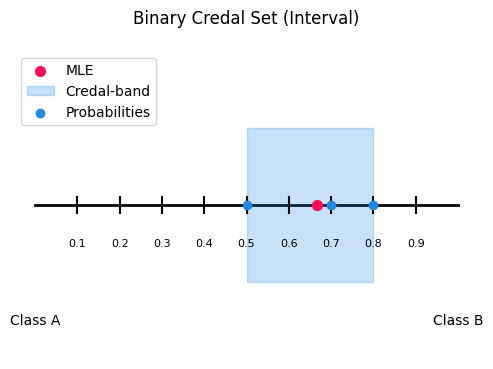

<Axes: title={'center': 'Binary Credal Set (Interval)'}>

In [2]:
points_2d = np.array(
    [
        [0.2, 0.8],
        [0.5, 0.5],
        [0.3, 0.7],
    ]
)

labels_2d = ["Class A", "Class B"]
create_credal_plot(
    input_data=points_2d,
    labels=labels_2d,
    title="Binary Credal Set (Interval)",
)

### 3.4 `plot_3d.py`
This module implements the **3-class credal visualization**: a *ternary plot* on the 2D probability simplex.

**Core idea:** <br>
If you have probabilities `[p1, p2, p3]` with `p1 + p2 + p3 = 1`, every prediction is a point inside the simplex. The closer a point is to a corner, the higher the probability of that class.

**Use a ternary plot when:**
- you have **exactly 3 classes**
- you want to visualize a **credal set** as a region (instead of just individual points)

**It’s especially useful for:**
- comparing **uncertainty structure**
- showing a **credal set** via the convex hull (and optionally min/max envelopes)

**Methods:**<br>
`TernaryVisualizer.probs_to_coords_3d()`: Converts each probability triple `[p1, p2, p3]` into 2D ternary coordinates `(x, y)` so it can be plotted in a triangle.

`TernaryVisualizer.ternary_plot()`: Draws the triangle simplex, axis ticks, and plots probability samples as points.
  - optional **MLE** (red dot): the mean probability vector when `mle_flag=True`
  - optional **MLE guide lines**: helper lines to make the MLE easier to read `draw_mle_prob_line`
  - optional **credal set**: the **convex hull** around all points when `credal_flag=True`
  - optional **min/max envelope lines**: draws up to 6 lines (min & max for each class) when `minmax_flag=True`

`TernaryVisualizer.plot_convex_hull()`: Builds convex hull around points, depending on how many probabilities are given.

`TernaryVisualizer.plot_minmax_lines()`: Computes per-class min and max probabilities across samples, then draws constant-probability lines for each bound.

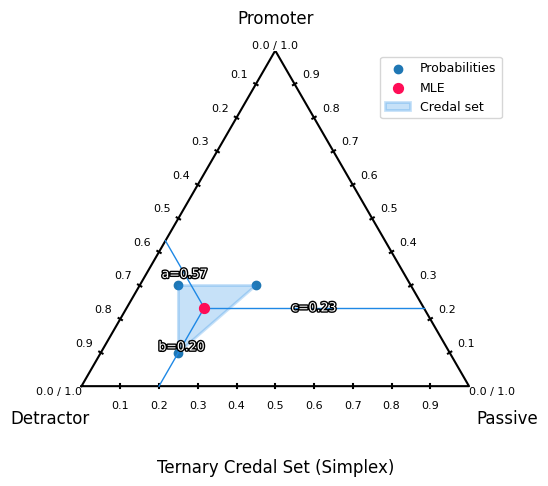

<Axes: title={'center': 'Ternary Credal Set (Simplex)'}>

In [3]:
points_3d = np.array(
    [
        [0.7, 0.2, 0.1],
        [0.4, 0.3, 0.3],
        [0.6, 0.1, 0.3],
    ]
)

labels_3d = ["Detractor", "Passive", "Promoter"]

create_credal_plot(
    input_data=points_3d,
    labels=labels_3d,
    title="Ternary Credal Set (Simplex)",
)

### 3.5 `plot_multid.py`
This module provides radar (spider) plots for multiclass probability predictions with **more than three classes.** It visualizes probability samples, MLE-style summaries, and credal uncertainty bands in a compact way. The plot is based on a custom Matplotlib radar projection created via `radar_factory`, supporting circular and polygonal frames.

**Core Idea:**<br>
Each axis corresponds to one class and the radius represents the predicted probability. For a probability vector `p = (p1,..., p)` with `sum(p) = 1`, only the dominant (maximum-probability) class of each sample is plotted. Optionally, a mean probability vector MLE-style and a per-class min–max credal band can be shown. This makes the plot suitable for ensemble outputs, robust classification, and imprecise probability models.
**Methods:**
`radar_factory():`
- Creates and registers a custom radar projection. Parameters: num_vars = number of classes; frame = “circle” or “polygon” (recommended).
- Returns: theta (np.ndarray, shape (num_vars,)) giving angular class positions.

`spider_plot()`:
- General spider plot for multiclass credal predictions.
- Input: probs (np.ndarray of shape (N, C), row-wise normalized) and labels (list of length C).
- Options: `mle_flag` shows the mean probability vector; `credal_flag` shows the min–max credal band; `ax` is an optional existing radar axis.

**Visualization:**<br>
**Sample points:** angle = most probable class, radius = probability value.
**MLE summary:** single point at the mean probability vector.
**Credal band:** shaded min–max envelope plus lower and upper bounds per class. Radial values lie in `[0, 1]`. For polygon frames, scaling uses `r_max = cos(π / C)`.

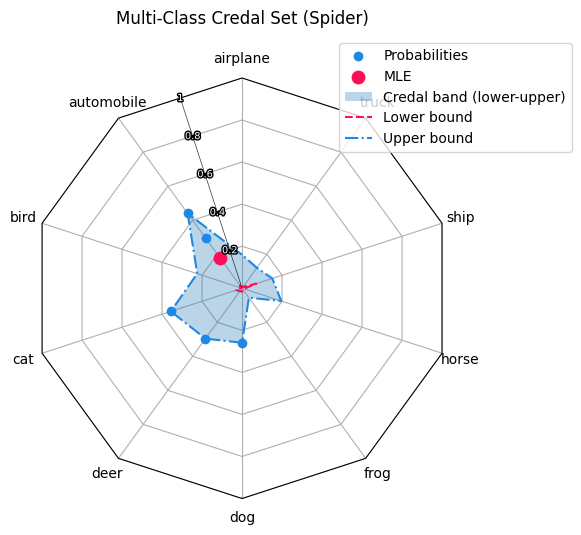

<RadarAxes: title={'center': 'Multi-Class Credal Set (Spider)'}>

In [4]:
n_classes = 10
n_samples = 5
points_multi = np.random.dirichlet(alpha=np.ones(n_classes), size=n_samples)

labels_multi = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

create_credal_plot(
    input_data=points_multi,
    labels=labels_multi,
    title="Multi-Class Credal Set (Spider)",
)

## 4. Specialized plots:
Besides the **credal based plots**, our visualization tool includes three further visualizations that focus on different aspects of uncertainty and reliability.

**Cluster-margin (SVM) uncertainty plot:**<br>
A 2D visualization that uses an SVM’s **distance to the decision boundary** as a *margin-based uncertainty*.
It highlights **where the ambiguous region between two clusters lies** in feature space (high uncertainty near the boundary).

**Dirichlet / Evidential plot:**<br>
A visualization tailored to **Dirichlet-based predictions** (common in evidential deep learning). It helps interpret not only the predicted class probabilities, but also the **strength / concentration** of the Dirichlet distribution (how “certain” the model is overall).

**Coverage–Efficiency plot:**<br>
A diagnostic plot for **prediction sets**. It shows the trade-off between **coverage** (how often the true label is included in the set) and **efficiency** (how small the set is on average). This is especially useful to compare behaviour on **ID vs. OOD** data.


### 4.1 `clustervisualizer.py`
The `clustervisualizer.py` is a simple visualization tool for inspecting how **confident a classifier separates two clusters** in a 2D feature space.
It is based on a **Support Vector Machine (SVM)** and highlights where the model is uncertain about a sample’s class belonging.<br>

**Core idea:**<br>
The visualization makes model uncertainty intuitive and easy to understand. Areas near the decision boundary appear highly uncertain, while regions farther away indicate higher confidence. As the two clusters move closer together or overlap, the region of uncertainty expands, demonstrating the difficulty of the classification. <br>
SVMs are **margin-based classifiers**. They **separate classes** by learning a decision boundary the maximizes the margin between samples of different classes. Using a soft margin allows misclassification but can improve the overall classification in the long run.

The SVM provides a margin-based confidence through its decision_function.
In this plot, the absolute margin values are inverted and normalized so that:<br>
- **High uncertainty:** values close to the decision boundary
- **Low uncertainty:** values far from the decision boundary

**What the plot shows:**
- A continuous uncertainty background derived from the SVM decision function
- The two input clusters overlaid as scatter points
- A colorbar indicating relative uncertainty
- Clear visual emphasis on ambiguous regions between classes

**Methods:** <br>
- `_check_shape()`: Validates that input arrays are NumPy arrays with shape **(n_samples, 2)** and are non-empty.

- `_2_cluster_to_x()`: Stacks the two clusters into a single feature matrix `X` with shape `(n1+n2, 2)`.

- `_2_cluster_to_y()`: Creates a label vector `y` of zeros (for cluster1) and ones (for cluster2), shape `(n1+n2,)`.

- `_plot_svm_beam()`: Builds a dense 2D grid over the data range, evaluates the SVM `decision_function`, converts absolute margin to uncertainty, normalizes it to `[0, 1]`, and plots it as a filled contour heatmap + colorbar.

- `plot_uncertainty()`: Main entry point.
	- validates `gamma` and `C`
	- scatters the two clusters with distinct colors
	- trains an `sklearn.svm.SVC` on `(X, y)`
	- overlays the uncertainty heatmap from `_plot_svm_beam`
	- optionally calls `plt.show()` and returns the Matplotlib `Axes`

**Model Parameters: To adapt the underlying SVM behaviour change those parameters**
- `Kernel`: SVM kernel type (`“linear”`, `“rbf”`, `“sigmoid”`)
- `C`: Regularization strength controlling tolerance for misclassification; Lower values allow more misclassification
- `gamma`: Kernel coefficient controlling the locality of influence; Higher values produce more localized decision boundaries

**Visualization Options:**<br>
- `title`: Plot title
- `x_label`, `y_label`: Axis labels
- `class_labels`: Custom names for the two classes
- `show`: If `True`, the plot is displayed immediately; If `False`, the Matplotlib Axes object is returned



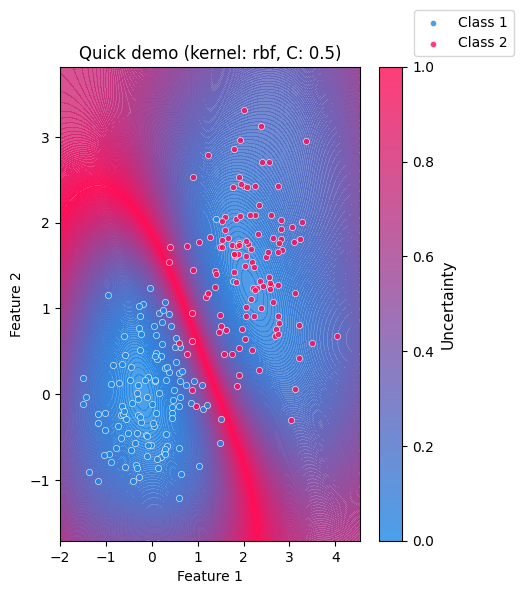

<Axes: title={'center': 'Quick demo (kernel: rbf, C: 0.5)'}, xlabel='Feature 1', ylabel='Feature 2'>

In [5]:
value = 42
rng = np.random.default_rng(value)

n1, n2 = 120, 120
cluster1 = rng.normal(loc=(0.0, 0.0), scale=0.7, size=(n1, 2))
cluster2 = rng.normal(loc=(2.0, 1.5), scale=0.7, size=(n2, 2))

plot_uncertainty(
    cluster1,
    cluster2,
    title="Quick demo",
    kernel="rbf",
    C=0.5,
    gamma="scale",
    show=True,
)

### 4.2 Dirichlet distribution plot
Dirichlet distribution plots visualize probability density over the simplex of categorical probability vectors. Each point in the ternary plot represents a possible distribution over three classes, and the contours show which distributions are more likely under a given α. In machine learning, these plots are used to understand and debug Bayesian priors for categorical and multinomial models. They make clear how α controls uncertainty, sparsity, and bias toward specific classes. This is especially useful in topic models, mixture models, and uncertainty-aware classifiers where probabilities themselves are treated as random variables.

#### How to generate a Dirichlet distribution plot:

The user needs to call upon the create_dirichlet_plot function. They may pass through parameters such as: alpha, title and labels. Although only alpha is needed; title and labels will be defaulted to: `“Dirichlet Distribution X, Y, Z”` and `"θ₁"`, `"θ₂"`, `"θ₃"`.


#### Notes on alpha values:
The alpha values must be **strictly positive**; zero or negative values are not allowed, as they do not define a valid Dirichlet distribution. Each `αᵢ` controls how strongly the distribution favors higher probability mass for class i. Larger `α` values lead to smoother, more concentrated distributions, while values less than 1 encourage sparse, peaked distributions near the simplex corners. Unequal `α` values bias the distribution toward specific classes, encoding prior beliefs about class dominance.

### 4.2.1 `dirichlet_visualization.py`

`dirichlet_visualization.py` is the user-facing API Module.

**Method:** <br>
- `create_dirichlet_plot()`: Asserts that the `np.array` has three alpha values, sets default labels/title if non are given and takes the parameters to plot the Dirichlet distribution

### 4.2.2 `plot_dirichlet.py`
`plot_dirichlet.py` is the module that handles the actual generation of the Dirichlet distribution plot.

**Methods:** <br>
- `triangle_corners()`: Returns the Cartesian coordinates of the three vertices of an equilateral ternary simplex.
- `xy_to_barycentric()`: Converts a Cartesian point inside the ternary triangle into barycentric coordinates with numerical clipping for stability.
- `pdf()`: Evaluates the Dirichlet probability density function at given barycentric coordinates.
- `label_corners_and_vertices()`: Annotates the ternary plot with corner labels, vertex values, and evenly spaced edge tick marks.
- `dirichlet_plot()`: Generates a filled contour plot of a Dirichlet distribution over a ternary simplex using a refined triangular mesh.

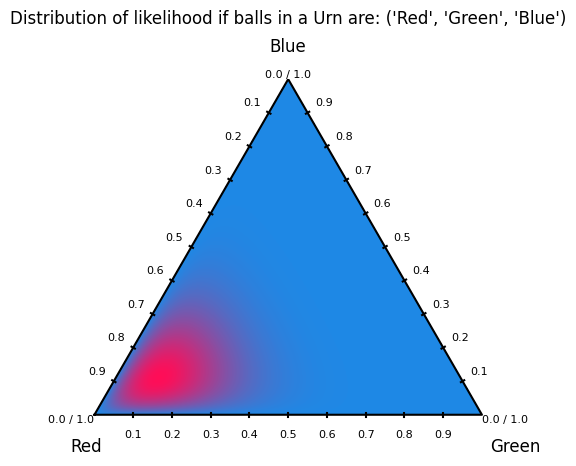

<Axes: title={'center': "Distribution of likelihood if balls in a Urn are: ('Red', 'Green', 'Blue')"}>

In [6]:
alpha_values = np.array([8, 2, 2])
labels = ("Red", "Green", "Blue")
title = f"Distribution of likelihood if balls in a Urn are: {labels}"

create_dirichlet_plot(alpha=alpha_values, labels=labels, title=title)

### 4.3 Coverage Efficency
These modules implement the **Coverage efficiency** visualization to evaluate how *trustworthy* a classifier is when using **prediction sets** instead of single-label predictions.<br>
The plot tracks two critical metrics:
- **Coverage (blue, reliability):**
  The fraction of samples where the **true class is included** in the predicted set.
  Ideally, empirical coverage follows the **diagonal “Ideal Coverage”** line (coverage ≈ target confidence).
  If coverage falls **below** the diagonal, the model is **overconfident** (it promises more safety than it delivers).

- **Efficiency (red, precision):**
  Measures how **small** the prediction set is on average (normalized).
  Here, efficiency is plotted as `1 - normalized_set_size`:
  - **1.0** ≈ very small sets (often size 1; very precise)
  - **0.0** ≈ very large sets (close to all classes; very uncertain)

A dangerous failure mode is: **coverage drops while efficiency stays high**: the model is making **confident but wrong** predictions.

**Interpretation:**
The visualization is based on **prediction sets** (similar in spirit to conformal prediction):
for a target confidence level `(1 - α)` the model outputs the **smallest set of top-k classes** whose cumulative probability mass reaches that confidence.

- **x-axis:** Target confidence level `(1 - α)` (the safety level requested by the user)
- **blue curve:** empirical coverage achieved by those sets
- **red curve:** efficiency (how compact the sets remain while meeting confidence)

**Explaination of OOD/ID**<br>
- **ID (in-distribution):** data similar to the training distribution
- **OOD (out-of-distribution):** data that differs from training (domain shift, novel patterns, etc.)

In an ideal OOD scenario, **efficiency should decrease** (sets expand) because the model correctly expresses uncertainty.
If efficiency stays high on OOD while coverage drops, the model is **overconfident under shift**.

**How to access the module:**<br>
`coverage_efficiency_ood.py` provides two main entry points:

- `plot_coverage_efficiency_id_ood(probs_id, targets_id, probs_ood, targets_ood, ...)`
  Use this if your data is **already split** into ID and OOD parts.

- `plot_coverage_efficiency_from_ood_labels(probs, targets, ood_labels, ...)`
  Use this if you have a **combined dataset** with binary markers (default convention: `0=ID`, `1=OOD`).
  The function automatically splits the arrays and calls the ID/OOD plotting routine.

**Inputs and configuration:**
- `probs`: must be a 2D array of shape **(N, C)** (class probabilities per sample; rows should sum to 1)
- `targets`: must be a 1D array of shape **(N,)** (integer class indices)
- `ood_labels` (optional): must be 1D of shape **(N,)** and use the chosen ID/OOD label convention

Styling (colors, fonts, line styles) is controlled centrally via `config.py` for consistent visuals across the library.

**Implementation overview (what the code actually does):**<br>

`CoverageEfficiencyVisualizer._compute_metrics()`:
- sorts probabilities per sample (descending)
- for each confidence level `(1 - α)`, selects the smallest top-k set reaching that cumulative probability
- computes:
  - **coverage**: whether the true label lies within that set
  - **efficiency**: average set size (later normalized)

`CoverageEfficiencyVisualizer.plot_coverage_efficiency()`:
- plots **ideal coverage** (diagonal) vs **empirical coverage** (blue)
- plots **efficiency** on a second y-axis (red), as `1 - normalized_set_size`
- returns the Matplotlib `Axes`

`coverage_efficiency_ood.py`:
- validates shapes
- plots ID and OOD **side-by-side**, or performs the split first when `ood_labels` are provided

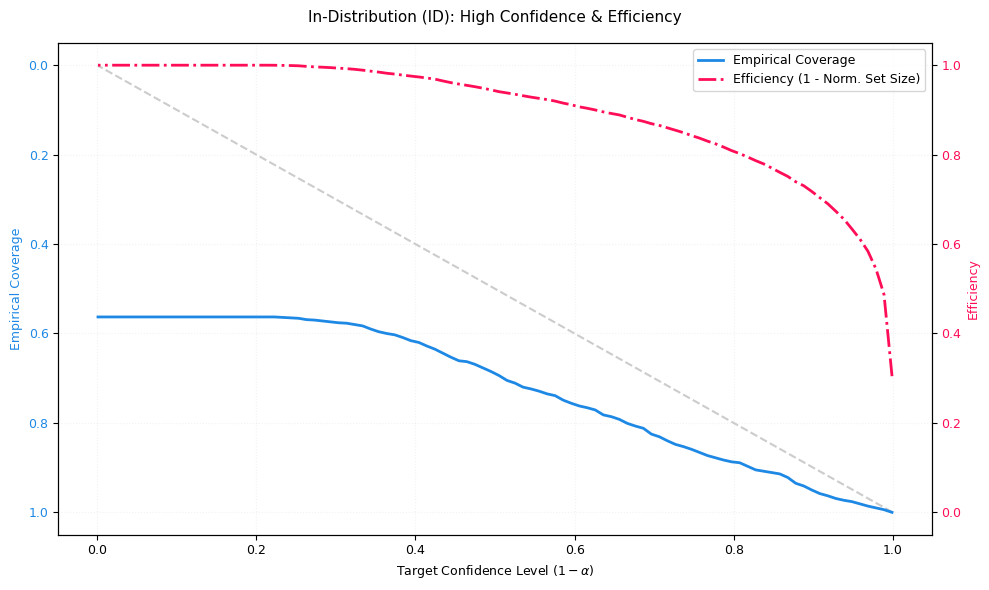

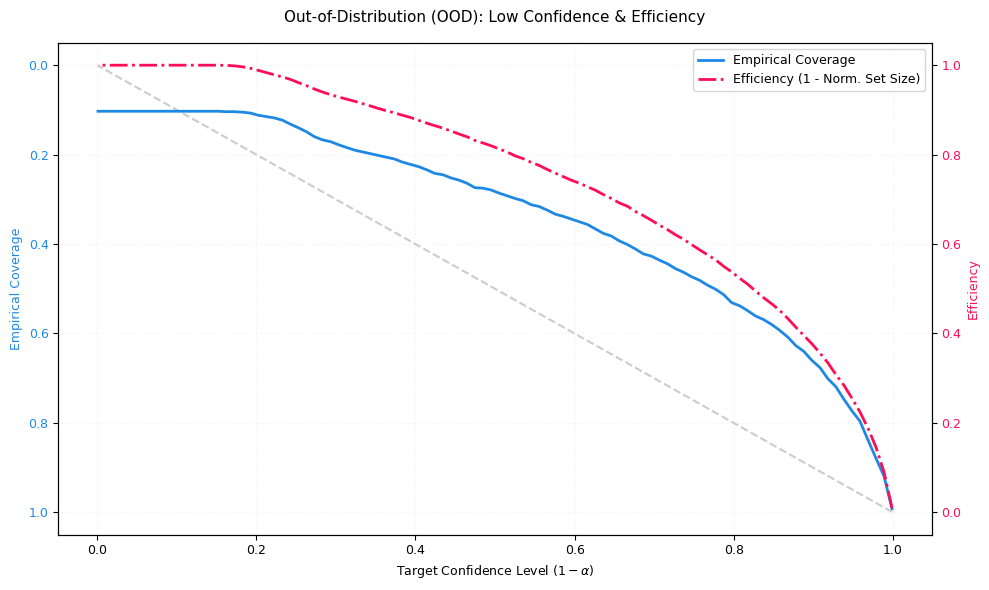

In [7]:
# In-Order Distribution:
n_samples = 1000
n_classes = 10

probs_id = np.random.dirichlet(alpha=np.ones(n_classes) * 0.2, size=n_samples)

targets_id = np.array([np.random.choice(n_classes, p=p) for p in probs_id])

fig, ax = plt.subplots(figsize=(10, 6))

visualizer.plot_coverage_efficiency(
    probs=probs_id, targets=targets_id, title="In-Distribution (ID): High Confidence & Efficiency", ax=ax
)

plt.tight_layout()
plt.show()

# Out-of-Order Distribution:
probs_ood = np.random.dirichlet(alpha=np.ones(n_classes) * 1.0, size=n_samples)

targets_ood = np.random.randint(0, n_classes, size=n_samples)

fig, ax = plt.subplots(figsize=(10, 6))

visualizer.plot_coverage_efficiency(
    probs=probs_ood, targets=targets_ood, title="Out-of-Distribution (OOD): Low Confidence & Efficiency", ax=ax
)

plt.tight_layout()
plt.show()

### 5. Further reading:
- **Credal:** {doc}`Credal Tutorial <evaluation_and_quantification/plotting_credal_tutorial>`
- **Clustermargin:** {doc}`Clustermargin Tutorial <evaluation_and_quantification/clustermargin_tutorial>`
- **Dirichlet:** {doc}`Dirichlet Tutorial <evaluation_and_quantification/dirichlet_tutorial>`
- **Coverage–Efficiency:** {doc}`Coverage-Efficiency Tutorial <evaluation_and_quantification/coverage_efficiency_tutorial>`